# Setup

In [1]:
!conda info --envs

# conda environments:
#
base                     C:\DDRIVE\ProgramFiles\Anaconda3
earth-analytics-python  *  C:\DDRIVE\ProgramFiles\Anaconda3\envs\earth-analytics-python
envhotzone               C:\DDRIVE\ProgramFiles\Anaconda3\envs\envhotzone
py36                     C:\DDRIVE\ProgramFiles\Anaconda3\envs\py36
wildfire                 C:\DDRIVE\ProgramFiles\Anaconda3\envs\wildfire



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import csv
import numpy as np
import os
import sqlite3
import copy
#from dbfread import DBF
import geopandas as gpd
import fiona
import pprint
import folium
#import descartes
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import features
import rasterio.mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import pickle
from scipy import stats

print(f"Python Version = {sys.version}")
print(f"Pandas Version = {pd.__version__}")
print(f"Geopandas Version = {gpd.__version__}")
print(f"rasterio version = {rio._base.gdal_version()}")

Python Version = 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:22:21) [MSC v.1916 64 bit (AMD64)]
Pandas Version = 1.0.3
Geopandas Version = 0.7.0
rasterio version = 3.0.4


# Definitions

1) Fine Fuel Moisture Code
The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.

2) Duff Moisture Code
The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.

3) Drought Code
The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.

4)  Initial Spread Index
The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It combines the effects of wind and the FFMC on rate of spread without the influence of variable quantities of fuel.

https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

5) Temp
Temperature in Celsius degrees

6) RH
Relative humidity in %

7) Wind
Wind speed in km/h

8) Rain
Outside rain in mm/m2

9) Area
The burned area of the forest (in ha), ha = hectare = 2.47 acres

10) X
x-axis spatial coordinate within the Montesinho park map: 1 to 9 2

11) Y
y-axis spatial coordinate within the Montesinho park map: 2 to 9 3

Literature:

https://news.uci.edu/2019/09/17/uci-team-uses-machine-learning-to-help-tell-which-wildfires-will-burn-out-of-control/

In the original paper (Portugal - Montesinho fires), the best result (predicting burned area) was only using the 4 weather conditions: RH/Wind/Rain/Temp, and an SVM.

This: https://datasetsearch.research.google.com/search?query=wildfire%20area&docid=fchFFzqh0O3qjX3PAAAAAA%3D%3D has georeferenced and date/time referenced with areas. Could combine with weather data for those dates/times.

# Query shape of datasets, type, feature names and how they work together

In [ ]:
os.getcwd()

## Global Fire Data  

If you want to see these easily on a map, visit: https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1642  

I have only pulled the 2016 data in in order to get a feel for it.

### DBF file

#### Ignitions

In [ ]:
globaldbf = DBF('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.dbf')

In [ ]:
len(globaldbf)

In [ ]:
records = list(globaldbf)

In [ ]:
print(records[0])

In [ ]:
df = pd.DataFrame(iter(globaldbf))

In [ ]:
df.head()

#### Perimeter

In [ ]:
perim2016 = DBF('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.dbf')

In [ ]:
perimdf = pd.DataFrame(iter(perim2016))

In [ ]:
perimdf.head()

### Shapefile - shp

#### Ignitions

In [ ]:
with fiona.open('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp') as src:
    pprint.pprint(src[0])

In [ ]:
gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp')

In [ ]:
gdf.head()

In [ ]:
#gdf.plot()

In [ ]:
gdf.geometry[:5]

In [ ]:
print(gdf.crs)

In [ ]:
gdf.columns.values

#### Perimeter

In [ ]:
gdf1 = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp')

In [ ]:
gdf1.head()

In [ ]:
gdf1.columns.values

In [ ]:
gdf1.geometry[0]

In [ ]:
gdf1[0:3].plot()

In [ ]:
%%time
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='lightgrey',linewidth=0.5,edgecolor='white',figsize = (20,8))
gdf1.plot(ax=ax)
plt.savefig('perimeters.png')

### PRJ file

In [ ]:
with open('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.prj') as f1:
    print(f"Ignitions Prj file contents = {f1.read()}")
    
with open('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.prj','r') as f2:
    print(f"Perimeter Prj file contents = {f2.read()}")    

The above mean:
- GEOGCS: Geographic coordinate reference system (vs. a projected coordinate system)
- WGS 84 : the name of the geographic coordinate reference system
- WGS_1984: The name of the DATUM
- SPHEROID: Used for the reference system with the semi major axis = 6378137 m and inverse-flattening ratio of 298.257223563
- PRIMEM: Greenwich is prime meridian where longitude is set as 0
- UNIT: measurement units of coordinate system, in degrees, where 0.01745.. is the conversion from radians to the units here(degrees)

### GEOTiff

#### Yearly TIFFs

In [ ]:
from rasterio.windows import Window

In [ ]:
%%time
diryr = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016.tif')
# speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
# dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
# firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')

In [ ]:
tifs = [diryr,speedyr,dobyr,firelineyr]

In [ ]:
for tif in tifs:
    print("name = ",tif.name)
    print("resolution of a pixel in units of coord reference system = ",tif.res)
    print("Image Structure tags =",tif.tags(ns='IMAGE_STRUCTURE'))
    print("tags =",tif.tags())
    print(tif.shape)
    print(tif.bounds)
    print("number of layers = ",tif.count)
    print("number of bands =", tif.indexes)
    print(tif.meta)
    print("\n\n")

In [ ]:
print(diryr.meta)
#customcrs = diryr.meta

In [ ]:
print(diryr.crs)

In [ ]:
customcrs = diryr.crs

#### Convert Lat/Long to CRS

From StackExchange:

You need to transform your points to the coordinate system of the raster. You could warp the raster to your points' coordinate system but warping rasters is a bit messy. (for R but should be similar in python)

https://gis.stackexchange.com/questions/200417/very-basic-question-on-extracting-data-from-tif-raster-layer-in-r-projection-n

Spatial Reference System, proj4: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs

In [ ]:
# Our desired 'fire' from the shapefile
fire

In [ ]:
fire.crs

In [ ]:
# Global Fire Atlas projection Coordinate Reference System (from website)
gfacrs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs" 

In [ ]:
fire2 = fire.to_crs(gfacrs)
fire2

In [ ]:
fire2.geometry.name

In [ ]:
fire2.crs  # Ah that is why you can't convert two columns. because when you convert one column
# then the entire dataframe thinks it is now in the new CRS

#### Reimport and engineer the features appropriately

First, don't combine the shp files. Instead, create 3 dataframes:  
1) fire ID and all the features (except geometry)  
2) fire ID and POLYGON  
3) fire ID and POINT (ignition)  

In [ ]:
%%time
ign_gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp')
poly_gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp')

In [ ]:
features1 = copy.deepcopy(ign_gdf)

In [ ]:
features1 = pd.DataFrame(ign_gdf.drop(columns='geometry'))
features1.head()

In [ ]:
colnames = list(ign_gdf.columns)

In [ ]:
keepnames = [colnames[0],colnames[len(colnames)-1]]
keepnames

In [ ]:
dropnames = list(set(colnames) - set(keepnames))

In [ ]:
ign_gdf.drop(columns=dropnames,inplace=True)

In [ ]:
dropnames2 = list(set(list(poly_gdf.columns)) - set(keepnames))
poly_gdf.drop(columns=dropnames2,inplace=True)

In [ ]:
# Global Fire Atlas projection Coordinate Reference System (from website)
gfacrs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs" 

#### Subset to California State

##### CA State Boundaries

From https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b

In [ ]:
%%time
#CA_gdf = gpd.read_file('../data/ca-state-boundary/CA_state_TIGER2016.shp')
CA_gdf = gpd.read_file('../data/ca-state-boundary/CA_State_TIGER2016.shp')

In [ ]:
CA_gdf

In [ ]:
CA_gdf.plot()

In [ ]:
CA_gdf.crs

##### Try a different approach - crop rasters to California

From Earth  data science: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/

In [ ]:
# Raster Data opened by rio is diryr
print(diryr.bounds)

In [ ]:
# Crop extent: CA_gdf
print('crop extent crs = \n', CA_gdf.crs)
print('tiff crs = \n', diryr.crs)

In [ ]:
# Set destination CRS
dst_crs = CA_gdf.crs

In [ ]:
%%time
# Calculate the transform using the rasterio warp function
transform,width,height = calculate_default_transform(diryr.crs,dst_crs,diryr.width,diryr.height,*diryr.bounds)

In [ ]:
%%time
# Set the new meta data for the projected raster file
kwargs = diryr.meta.copy()
kwargs.update({'crs':dst_crs,
              'transform':transform,
              'width':width,
              'height':height
              })

In [ ]:
%%time
# write the new raster file by using the rasterio reproject function
with rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif','w',**kwargs) as dst:
    for i in range(1, diryr.count + 1):
        reproject(
            source = rio.band(diryr,i),
            destination=rio.band(dst,i),
            diryr_transform = diryr.transform,
            diryr_crs = diryr.crs,
            dst_transform = transform,
            dst_crs = dst_crs,
            resampling=Resampling.nearest)

In [ ]:
%%time
# Open the new reprojected geotiff
diryr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif')
print(diryr_reproj.meta)

In [ ]:
%%time
# Crop extent: CA_gdf - crop to the boundaries of California, which should work now that both raster 
# and shapefile are on the same CRS
print('crop extent crs = \n', CA_gdf.crs)
print('tiff crs = \n', diryr_reproj.crs)

In [ ]:
%%time
# Use the earthpy.spatial function to crop the tif by the shapefile
diryr_reproj_crop, diryr_reproj_crop_meta = es.crop_image(diryr_reproj,CA_gdf)

In [ ]:
print("cropped data", diryr_reproj_crop.shape)
print("original data", diryr.shape)

In [ ]:
# Use the affine transformation for the CRS to define the extents
diryr_reproj_crop_affine = diryr_reproj_crop_meta["transform"]
diryr_reproj_extent = plotting_extent(diryr_reproj_crop[0],diryr_reproj_crop_affine)

In [ ]:
diryr_reproj_crop_meta

In [ ]:
fig,ax = plt.subplots(figsize=(10,16))
ep.plot_bands(diryr_reproj_crop,
              extent = diryr_reproj_extent,
              cmap='Greys',
              title = 'Direction',
              scale=False,
              ax=ax,
              cbar=False)

CA_gdf.plot(ax=ax,alpha=0.2)
ax.set_axis_off()
plt.show()

In [ ]:
vals = diryr_reproj_crop[0][diryr_reproj_crop[0]>0]
vals

In [ ]:
print(type(vals),vals.shape)
stats.describe(vals)

##### Transform Ignition and polygons of final fire sizes to CA CRS

In [ ]:
# transform CRS
ign2 = ign_gdf.to_crs(dst_crs)
poly2 = poly_gdf.to_crs(dst_crs)

In [ ]:
# set area to crop to
bb = CA_gdf.envelope

In [ ]:
# Crop polygons of final fire sizes using geopandas overlay
df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb),columns=['geometry'])
poly2crop = gpd.overlay(df2,poly2,how='intersection')

In [ ]:
# Use dataframe slicing for the ignition point data.
xmin,ymin,xmax,ymax=CA_gdf.total_bounds
ign2crop = ign2.cx[xmin:xmax,ymin:ymax]

In [ ]:
fig,ax = plt.subplots(figsize=(10,16))
ep.plot_bands(diryr_reproj_crop,
              extent = diryr_reproj_extent,
              cmap='Greys',
              title = 'Direction',
              scale=False,
              ax=ax,
              cbar=False)

CA_gdf.plot(ax=ax, alpha=0.2)
ign2crop.plot(ax=ax,marker='x',color='green',markersize=12)
poly2crop.plot(ax=ax,alpha=0.4)
ax.set_axis_off()
plt.show()

#### Create new bounding box for smaller section of CA and convert CRS
Repeat above process for cropping

In [ ]:
# Set source CRS - this is the google maps CRS
bb_gdf_orig.crs = {'init':'epsg:4326'}
print(bb_gdf_orig.crs)

In [ ]:
# Create bounding box polygon from lat long pulled from Gmaps
from shapely.geometry import Polygon
bb_long = [-122, -119.912,-119.912,-122,-122 ]
bb_lat = [36.8, 36.8, 35.06, 35.06,36.8]
bb_poly = Polygon(zip(bb_long,bb_lat))
bb_gdf2 = gpd.GeoDataFrame(index=[0],crs=bb_gdf_orig.crs,geometry = [bb_poly])
print(bb_gdf2.geometry)

In [ ]:
# Change CRS of polygon to match other work here
bb_gdf2 = bb_gdf2.to_crs(epsg=3857)
bb_gdf2

In [ ]:
# Plotting
fig,ax = plt.subplots(figsize=(10,16))
ep.plot_bands(diryr_reproj_crop,
              extent = diryr_reproj_extent,
              cmap='Greys',
              title = 'Direction',
              scale=False,
              ax=ax,
              cbar=False)

CA_gdf.plot(ax=ax, alpha=0.2)
ign2crop.plot(ax=ax,marker='x',color='green',markersize=12)
poly2crop.plot(ax=ax,alpha=0.4)
bb_gdf2.plot(ax=ax,color='green',alpha=0.2)
ax.set_axis_off()
plt.show()

#### Convert CRS for remaining raster files

In [ ]:
# Raster Data opened by rio 
#speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
#dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
#firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')
print('speedyr bounds =',speedyr.bounds)
print('dobyr bounds =',dobyr.bounds)
print('firelineyr bounds =',firelineyr.bounds)

In [ ]:
# Set destination CRS
dst_crs = bb_gdf2.crs

In [ ]:
tifs = [(speedyr,'speed'),(dobyr,'dob'),(firelineyr,'fireline')]

In [ ]:
# Commented out this whole box because files have been saved already NEXT TIME - ADD COMPRESSION - 
# FILES WERE HUGE (see commented line below) OR reproject to new array, then write out with compression
# %%time
# for tif in tifs:
#     file,name = tif
    
#     # Calculate the transform using the rasterio warp function
#     transform,width,height = calculate_default_transform(file.crs,dst_crs,file.width,file.height,*file.bounds)
    
#     # Set the new meta data for the projected raster file
#     kwargs = file.meta.copy()
#     kwargs.update({'crs':dst_crs,
#                   'transform':transform,
#                   'width':width,
#                   'height':height
#                   #compress:'lzw'
#                   })
    
#     # Filename for writing out to
#     filestring = '../data/GlobalFire2016/Global_fire_atlas_' + name + '_yearly_2016_reproj.tif'
    
#     # write the new raster file by using the rasterio reproject function
#     with rio.open(filestring,'w',**kwargs) as dst:
#         for i in range(1, file.count + 1):
#             reproject(
#                 source = rio.band(file,i),
#                 destination=rio.band(dst,i),
#                 file_transform = file.transform,
#                 file_crs = file.crs,
#                 dst_transform = transform,
#                 dst_crs = dst_crs,
#                 resampling=Resampling.nearest)  

In [ ]:
# Close all the previous readers
diryr.close()
dobyr.close()
firelineyr.close()
speedyr.close()

#### Crop to smaller bounding box - Toy Set

In [ ]:
# Check CRSs all match
print('ignition CRS', ign2.crs)
print('final polygon CRS', poly2.crs)
print('bounding box CRS', bb_gdf2.crs)

##### First the ignition points to get fire numbers and then final fire sizes and dbf data

In [ ]:
print('bounding box extents', bb_gdf2.total_bounds)

In [ ]:
# Crop Ignition Data
xmin2,ymin2,xmax2,ymax2=bb_gdf2.total_bounds
ign2crop2 = ign2.cx[xmin2:xmax2,ymin2:ymax2]

In [ ]:
print(ign2crop2.shape, ign2.shape)

In [ ]:
fires = ign2crop2['fire_ID'].values

In [ ]:
poly2crop2 = poly2.loc[poly2['fire_ID'].isin(fires)]

In [ ]:
print(poly2crop2.shape, poly2.shape)

In [ ]:
featurescrop2 = features1.loc[features1['fire_ID'].isin(fires)]

In [ ]:
featurescrop2.head()

In [ ]:
ign2crop2.head()

In [ ]:
%%time
#pickle out the ignition points and dbf
with open('../data/GlobalFire2016/Global_fire_atlas_ignitioncrop.pickle','wb') as f:
    pickle.dump(ign2crop2,f,pickle.HIGHEST_PROTOCOL)
with open('../data/GlobalFire2016/Global_fire_atlas_datacrop.pickle','wb') as f:
    pickle.dump(featurescrop2,f,pickle.HIGHEST_PROTOCOL)

##### Crop the rasters

In [ ]:
# Open the new reprojected geotiffs
diryr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif')
speedyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016_reproj.tif')
dobyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_dob_yearly_2016_reproj.tif')
firelineyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_fireline_yearly_2016_reproj.tif')

In [ ]:
# Crop extent: bb_gdf2 - crop to the small box, which should work now that both raster 
# and shapefile are on the same CRS
print('crop extent crs = ', bb_gdf2.crs)
print('direction tiff crs = ', diryr_reproj.crs)
print('speed tiff crs = ', speedyr_reproj.crs)
print('day of burn tiff crs = ', dobyr_reproj.crs)
print('fireline tiff crs = ', firelineyr_reproj.crs)

In [ ]:
def crop_tif(tif_reproj,boundingbox):
    """function to crop the reprojected tiffs by the bounding box (shapefile)"""
    
    tif_reproj_crop,tif_reproj_crop_meta = es.crop_image(tif_reproj,boundingbox)
    print("cropped data", tif_reproj_crop.shape)
    print("original data", tif_reproj.shape)
    print("meta", tif_reproj_crop_meta)
       
    return(tif_reproj_crop, tif_reproj_crop_meta)

In [ ]:
%%time
diryr_reproj_crop,diryr_reproj_crop_meta = crop_tif(diryr_reproj,bb_gdf2)
speedyr_reproj_crop,speedyr_reproj_crop_meta = crop_tif(speedyr_reproj,bb_gdf2)
dobyr_reproj_crop,dobyr_reproj_crop_meta = crop_tif(dobyr_reproj,bb_gdf2)
firelineyr_reproj_crop,firelineyr_reproj_crop_meta = crop_tif(firelineyr_reproj,bb_gdf2)

In [ ]:
vals = firelineyr_reproj_crop[0][firelineyr_reproj_crop[0]>0]
vals

In [ ]:
diryr_reproj.close()
speedyr_reproj.close()
dobyr_reproj.close()
firelineyr_reproj.close()

In [ ]:
# Write these out to smaller tiffs
with rio.open('../data/GlobalFire2016/Global_fire_atlas_dircrop.tif','w',**diryr_reproj_crop_meta) as dst:
    dst.write(diryr_reproj_crop)
with rio.open('../data/GlobalFire2016/Global_fire_atlas_speedcrop.tif','w',**speedyr_reproj_crop_meta) as dst:
    dst.write(speedyr_reproj_crop)
with rio.open('../data/GlobalFire2016/Global_fire_atlas_dobcrop.tif','w',**dobyr_reproj_crop_meta) as dst:
    dst.write(dobyr_reproj_crop)
with rio.open('../data/GlobalFire2016/Global_fire_atlas_firelinecrop.tif','w',**firelineyr_reproj_crop_meta) as dst:
    dst.write(firelineyr_reproj_crop)

#### Create a new tiff with fire_ID as the value
Determine if a raster pixel is in a fire polygon and create a new tiff with fire_ID as the value

In [ ]:
# From https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python
polys = poly2crop2
rst_fn = '../data/GlobalFire2016/template.tif'
out_fn = '../data/GlobalFire2016/fireid.tif'

In [ ]:
rst = rio.open(rst_fn)
metaout = rst.meta.copy()
metaout.update(compress='lzw')

In [ ]:
with rio.open(out_fn, 'w+',**metaout) as out:
    out_arr = out.read(1)
    
    shapes = ((geom,value) for geom,value in zip(polys.geometry,polys.fire_ID))
    
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1,burned)

In [ ]:
fireid = rio.open('../data/GlobalFire2016/fireid.tif')
print(fireid.meta)

In [ ]:
fireid_array = fireid.read()

In [ ]:
fireid_array.shape

In [ ]:
print(fireid_array)

In [ ]:
vals = fireid_array[0][fireid_array[0]>0]
vals

In [ ]:
len(vals)

# Data Pipeline Functions

## Read in California Shape

In [1]:
def get_cali(path, filename):
    """readin shp file and return destination geodataframe and CRS"""
    filestring = path+filename
    dst_gdf = gpd.read_file(filestring)
    dst_crs = dst_gdf.crs
    return (dst_gdf,dst_crs)

## Crop Raster Data Function

In [41]:
def crop_raster(crop_gdf,tiff_path,tiff_filename,new_prefix):
    """ Crop the raster data to a smaller size based on a gdf
    Input: gdf with polygon of crop boundaries
    Output: Cropped Raster in its original CRS
    """
    
    # Open tiff
    orig_tif_file = tiff_path + tiff_filename
    orig_tif = rio.open(orig_tif_file)
    
    # Get crs for tiff
    tif_crs = orig_tif.crs
    # Get crs for crop_gdf
    gdf_crs = crop_gdf.crs
    
    #Transform the gdf crs
    bbgdf = crop_gdf.to_crs(tif_crs)
    
    # Crop if the crs's match:
    if tif_crs == bbgdf.crs:
        tif_crop,tif_crop_meta = es.crop_image(orig_tif,bbgdf)
    else:
        print(f"CRSs do not match. Tif CRS: {tif_crs}, \ngdf_crs: {bbgdf.crs}")
    
    # Write out smaller tifs
    newtif_name = new_prefix+tiff_filename
    newtif_filestring = tiff_path+newtif_name
    
    kwargs = orig_tif.meta.copy()
    kwargs.update({'crs':tif_crs,
                   'width':tif_crop_meta['width'],
                   'height':tif_crop_meta['height'],
                   'transform':tif_crop_meta['transform'],
                   'compress':'lzw'
                  })
    with rio.open(newtif_filestring,'w',**kwargs) as smaller:
        smaller.write(tif_crop)
    
    # Close tifs
    orig_tif.close()
    
    return newtif_name

## Reproject Raster Data to EPSG 3857 and Save Out  


In [3]:
def reproject_raster(dst_crs,tiff_path,tiff_filename):
    """Using the destination crs and the input raster
    create a reprojected raster file
    
    Input: Destination Crs and Tiff file in original format
    Output: Status of File Write
    """
    # Get tiff crs and dimensions
    tiff_filestring = tiff_path + tiff_filename
    raster = rio.open(tiff_filestring)
    print(f"Filename {tiff_filestring} and Original raster meta {raster.meta} \n dest crs: {dst_crs}\n raster bounds: {raster.bounds}")
    
    # Calculate the transform using the rasterio warp function
    transform,width,height = calculate_default_transform(raster.crs,dst_crs,raster.width,raster.height,*raster.bounds)
    print(f"Newtransform: {transform}, new width: {width}, new height: {height} ")
    
    # Set the new meta data for the projected raster file
#     kwargs = raster.meta.copy()
#     kwargs.update({'crs':dst_crs,
#                    'transform':transform,
#                    'width':width,
#                    'height':height,
#                    'compress':'lzw'
#                   })
    
#     # write the new raster file by using the rasterio reproject function
#     dst_filename = 'Reproj_'+tiff_filename
#     dst_filestring = tiff_path+dst_filename
#     dst = rio.open(dst_filestring,'w',**kwargs)
#     for i in range(1, raster.count + 1):
#         reproject(
#             source = rio.band(raster,i),
#             destination=rio.band(dst,i),
#             raster_transform = raster.transform,
#             raster_crs = raster.crs,
#             dst_transform = transform,
#             dst_crs = dst_crs,
#             resampling=Resampling.nearest)
    
#     print("destination raster meta",dst.meta)
#     # Close raster files
#     raster.close()
#     dst.close()
    
    return dst_filename

## Crop Ignition and Perimeter Files and Save Out

In [4]:
def crop_ign(bb_gdf,path,year):
    """Takes the cropping bounding box and input files of ignition and final
    fire polygon data and crops
    Input: bb_gdf - bounding box dataframe, path and year of ignition and final fire perimeter polygon data
    Output: BBign and BBpoly dataframes and list of fires
    """
    ignfilestring = "zip://"+path+"Global_fire_atlas_V1_ignitions_"+year+".zip!Global_fire_atlas_V1_ignitions_"+year+".shp"
    polyfilestring = "zip://"+path+"Global_fire_atlas_V1_perimeter_"+year+".zip!Global_fire_atlas_V1_perimeter_"+year+".shp"
    ign_gdf = gpd.read_file(ignfilestring)
    poly_gdf = gpd.read_file(polyfilestring)
    
    ign_crs = ign_gdf.crs
    poly_crs = poly_gdf.crs
    bb_crs = bb_gdf.crs
    
    # If Crs doesn't match, then convert
    if ign_crs != bb_crs:
        # transform CRS
        ign_gdf = ign_gdf.to_crs(bb_crs)
        
    if poly_crs != bb_crs:
        # transform CRS
        poly_gdf = poly_gdf.to_crs(bb_crs)
        
    # Crop polygons of final fire sizes using geopandas overlay
    df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb_gdf.envelope),columns=['geometry'],crs=bb_crs)
    poly_crop = gpd.overlay(df2,poly_gdf,how='intersection')
    
    fires = poly_crop['fire_ID'].values
    ign_crop = ign_gdf[ign_gdf['fire_ID'].isin(fires)]
    
    # take all columns except fire ID and geometry out
    ign_crop = ign_crop[['fire_ID','geometry']]
    poly_crop = poly_crop[['fire_ID','geometry']]
    
    ignition_file = path+'ignitioncrop.pickle'
    perim_file = path+'polygoncrop.pickle'
    with open(ignition_file,'wb') as f:
        pickle.dump(ign_crop,f,pickle.HIGHEST_PROTOCOL)
    with open(perim_file,'wb') as f1:
        pickle.dump(poly_crop,f1,pickle.HIGHEST_PROTOCOL)

    return (ign_crop,poly_crop,fires) 

## Create Fire ID Raster and Save Out  
- ensure that Raster to Array conversion is saved as well

In [5]:
def create_fireidtif(path,polys):
    """Take path name and polygons for fires in bounding box and save out fireid Raster
    Input: path for given year and cropped polygon dataframe
    Output: save out fire_id raster and return true
    """
    
    rst_fn = path+'BBfirelineCA.tif'
    out_fn = path+'BBfireid.tif'
    
    with rio.open(rst_fn) as f:
        meta = f.meta    
    
    metaout = meta.copy()
    metaout.update(compress='lzw')
    
    shapes = ((geom,value) for geom,value in zip(polys.geometry,polys.fire_ID))
    
    with rio.open(out_fn, 'w+',**metaout) as out:
        out_arr = out.read(1)
        burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
        out.write_band(1,burned)
        
    return True

## Run Pipeline

In [42]:
%%time
import geopandas as gpd
import rasterio as rio
from shapely.geometry import Polygon
import earthpy.spatial as es
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import features
import pickle

# Create Berkeley area Bounding Box
bb_crs = "epsg:4326" # Long/Lat from map
bblong = [-123.5, -119.5,-119.5,-123.5,-123.5]
bblat = [39, 39, 36, 36,39]
bbpoly = Polygon(zip(bblong,bblat))
bbgdf = gpd.GeoDataFrame(index=[0],crs=bb_crs,geometry = [bbpoly])

#eventually
# years = ['2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016',]
# for year in years:
    
# Build list of tif file names to crop
year = '2016'  # remove when in loop over years
src_path = '../data/GlobalFire/'+year+'/'
firevars = ['dayofburn','direction','fireline','speed']
filenames = []
for var in firevars:
    filename = var+'CA'+'.tif'
    filenames.append(filename)
        
# Crop rasters to smaller box
bb_filenames=[]
for file in filenames:
    bbname = crop_raster(bbgdf,src_path,file,new_prefix='BB')
    bb_filenames.append(bbname)

#Crop Ignition File and get FireIDs for bb
ign_crop,poly_crop,fires = crop_ign(bbgdf,src_path,year)
    
# Create FireID raster
created_tif = create_fireidtif(src_path,poly_crop)

if created_tif:
    print(f"year {year} has completed processing")
    print(f"fire ids for fires in year {year} are:\n{fires}")
else:
    print(f"something went wrong in processing year {year}")

year 2016 has completed processing
fire ids for fires in year 2016 are:
[ 89  90  86  88  87  98  97  96  95  94  91  93  92 114 113 110 109 111
 108 103 101 102 100  99 117 136 132 133 131 121 170 167 165 162 166 161
 164 163 143 142 140 141 152 147 149 146 148 144 138]
Wall time: 6min 31s


### Check Processing Completed OK

In [43]:
def plot_fires(bbgdf, path, year):
    
    from rasterio.plot import plotting_extent
    import descartes
    import earthpy.plot as ep
    import matplotlib.pyplot as plt
    
    ignitions = path+'ignitioncrop.pickle'
    polygons = path+'polygoncrop.pickle'
    with open(ignitions,'rb') as f1:
        ig = pickle.load(f1)
    with open(polygons,'rb') as f2:
        pl = pickle.load(f2)
    
    CA_gdf,CA_crs = get_cali('../data/ca-state-boundary/','CA_State_TIGER2016.shp')
    CA_gdf = CA_gdf.to_crs(ig.crs)
    
    #sample raster
    rasterfile = path+'BBdayofburnCA.tif'
    rst = rio.open(rasterfile)
    data = rst.read(1)
    
    rst_affine = rst.meta["transform"]
    rst_extent = plotting_extent(rst,rst_affine)
    
    # Plotting
    fig,ax = plt.subplots(figsize=(10,16))
    ep.plot_bands(data,
                  extent = rst_extent,
                  cmap='Greys',
                  title = 'DayOfBurn',
                  scale=False,
                  ax=ax,
                  cbar=False)

    CA_gdf.plot(ax=ax, alpha=0.2)
    ig.plot(ax=ax,marker='x',color='green',markersize=12)
    pl.plot(ax=ax,alpha=0.4)
    bbgdf.plot(ax=ax,color='green',alpha=0.2)
    ax.set_axis_off()
    plt.show()
    
    rst.close()
    
    return

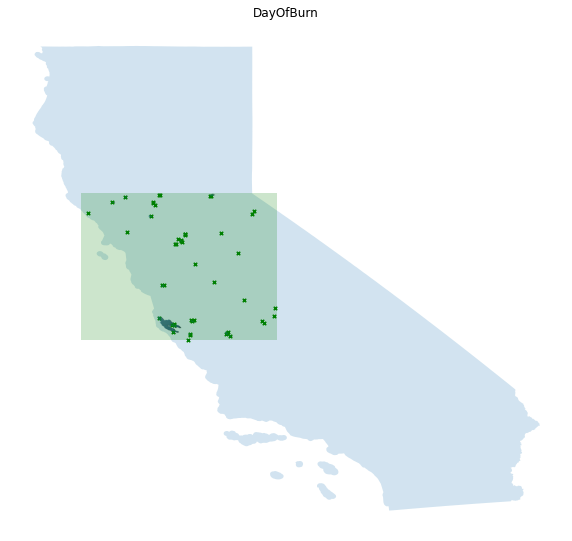

In [44]:

plot_fires(bbgdf,src_path,year)

In [49]:
def plot_rasters(rasters):
    """ Plot all the fire data rasters for 2016 as heatmaps"""
    fig = plt.figure(figsize = (20,4))
    fig.suptitle('Bounded Fire Data showing Sparsity 2016')
    fig.subplots_adjust(hspace=0.4)
    i=1
    for key,data in rasters.items():
        ax = fig.add_subplot(1,4,i)
        sns.heatmap(data)
        ax.set_title(key)
        i+=1
    plt.savefig('HeatmapFireData.jpg')
    plt.show()

../data/GlobalFire/2016/BBdayofburnCA.tif


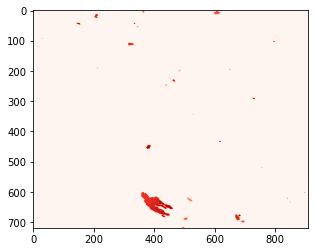

../data/GlobalFire/2016/BBdirectionCA.tif


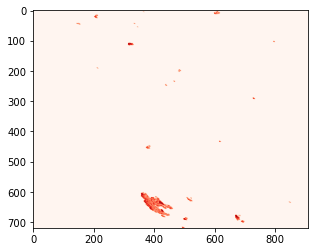

../data/GlobalFire/2016/BBfirelineCA.tif


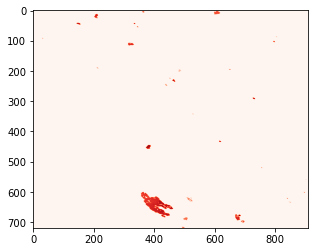

../data/GlobalFire/2016/BBspeedCA.tif


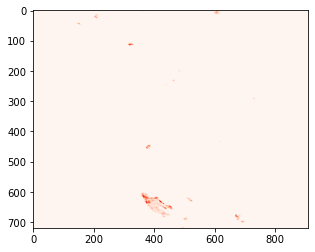

../data/GlobalFire/2016/BBfireid.tif


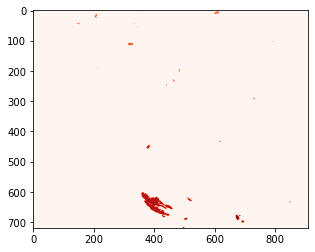

In [50]:
for file in bb_filenames:
    filex = src_path+file
    with rio.open(filex) as f:
        ff = f.read(1)
        print(filex)
        plt.figure()
        plt.imshow(ff, cmap='Reds')    
        plt.show()
fireidtif = src_path+'BBfireid.tif'
with rio.open(fireidtif) as f1:
    print(fireidtif)
    ff1 = f1.read(1)
    plt.figure()
    plt.imshow(ff1,cmap='Reds')
    plt.show()